In [21]:
import numpy as np 
from sklearn.datasets import load_digits

In [22]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [23]:
X , y = digits["data"], digits["target"]
X.shape

(1797, 64)

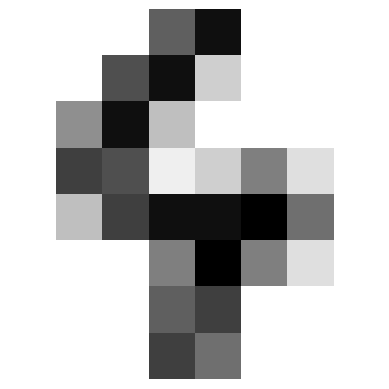

In [24]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 

some_digit = X[110]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [25]:
y[110]

4

In [26]:
y = y.astype(np.uint8)

In [27]:
X_train , X_test, y_train, y_test = X[:1500], X[1500:], y[:1500], y[1500:]

In [28]:
y_train_5  = (y_train == 4) # true for all 5`s
y_test_5 = (y_test == 4) 

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class.This classifier has the advantage of being capable of handling very large datasets efficiently.

In [29]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detech images of number 5

In [30]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring accuracy using cross validation

In these cases, you can implement cross-validation yourself; it is actually fairly straightforward. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and prints the same result:

The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/ len(y_pred))


0.996
0.996
0.996


Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds.

In [32]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.996, 0.98 , 0.998])

let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [33]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.902, 0.902, 0.9  ])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## Confusion Matrix

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets.

In [35]:
from sklearn.model_selection import cross_val_predict

y_tarin_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [36]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

confusion_matrix(y_train_5, y_tarin_pred)

array([[1345,    7],
       [   6,  142]])

In [37]:
y_train_perfect_pred = y_train_5 #pretend we attained perfection
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[1352,    0],
       [   0,  148]])

precision: $ TP / (TP+FP) $

recall : $ TP / (TP + FN) $ this is the ratio of positive instances that are correctly detected by the classifier



In [38]:
precision_score(y_train_5, y_tarin_pred)

0.9530201342281879

In [39]:
recall_score(y_train_5, y_tarin_pred)

0.9594594594594594

It is often convenient to combine precision and recall into a single metric called the $ F1 $ score, in particular if you need a simple way to compare two classifiers. The $F1$ score is the harmonic mean of precision and recall.

$$
    F1 = 2 / (1/precision + 1/recall)
$$

In [40]:
f1_score(y_train_5, y_tarin_pred)

0.9562289562289562

Increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

# Precision/Recall Tradeoff

In [41]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1407.96648118])

In [42]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., False). Let’s increase the threshold

In [43]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 4, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.

Now how do you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresh‐
olds using the precision_recall_curve() function

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

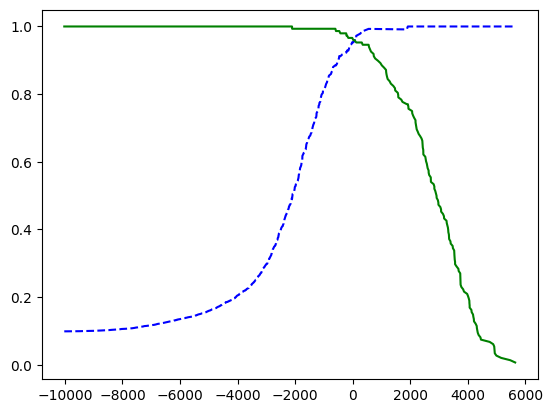

In [46]:
def plot_presision_recall_vs_threshold(precisions, recalls , thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[: -1], "g-", label="recall")

plot_presision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thrrsholds = roc_curve(y_train_5, y_scores)

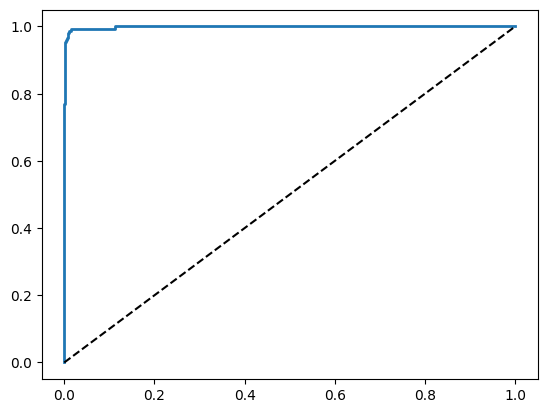

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--") #dashed diagnol
    #add axis labels and grid


plot_roc_curve(fpr, tpr)
plt.show()


Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9987555973132897

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest , thresholds_forest = roc_curve(y_train_5, y_scores_forest)

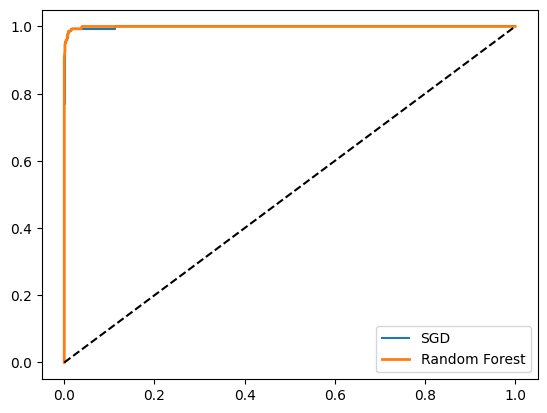

In [56]:
plt.plot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.legend(loc="lower right")
plt.show()

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9993478130497362

***Now let’s try to detect more than just the 4s.***

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [59]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-2740.84850915, -2264.69214446, -5954.49690514, -1986.80418467,
         1609.4031399 ,  -551.96642308,  -824.29823114,  -869.32302935,
        -2321.75160302, -3682.42939757]])

In [60]:
np.argmax(some_digit_scores)

4

In [61]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [66]:
sgd_clf.classes_[4]

4

In [68]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=uint8)

In [69]:
len(ovo_clf.estimators_)

45

In [70]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([4], dtype=uint8)

In [71]:
forest_clf.predict_proba([some_digit])

array([[0.02, 0.  , 0.  , 0.  , 0.87, 0.05, 0.01, 0.03, 0.  , 0.02]])

In [72]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.904, 0.904, 0.946])

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # increase in accuracy after scaling

array([0.91 , 0.898, 0.958])